# **Intoduction**
* This notebook will show you how to improve data piplines with Data Augmentation for small Datasets in Tensorflow.

# **Prepare and Import Libraries**

In [ ]:
! pip install tensorflow==2.1.0

In [ ]:
import os
import math
import numpy as np
import tensorflow as tf 
import tensorflow_addons as tfa
import matplotlib.pyplot as plt

from pathlib import Path
from tqdm import notebook

In [ ]:
tf.__version__

'2.1.0'

# **Download Datsset**

In [ ]:
train_data_fp = tf.keras.utils.get_file(origin='https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
                                        fname='/content/flowers',untar=True)

228818944/228813984 [==============================] - 4s 0us/step


In [ ]:
# Extract Data
! tar -xf /content/flowers.tar.gz

# **Initialize Parameters**

In [ ]:
channels = 3
batch_size = 64
img_width = 256
img_height = 256

AUTOTUNE = tf.data.experimental.AUTOTUNE

In [ ]:
base_dir = Path('/content/flower_photos')
CLASS_NAMES = np.array([item.name for item in base_dir.glob('*') if item.name != 'LICENSE.txt'])
print(CLASS_NAMES)

['tulips' 'dandelion' 'daisy' 'sunflowers' 'roses']


# **Helper Functions**

In [ ]:
def show_batch(images: np.ndarray, labels: np.ndarray = None, fig_num: int = 3):
    plt.figure(figsize=(10, 10))
    count = fig_num * fig_num
    for idx, img in enumerate(images):
        plt.subplot(fig_num, fig_num, idx + 1)
        plt.xticks([])
        plt.yticks([])
        if labels is not None:
            label = CLASS_NAMES[labels[idx] == 1][0]
            plt.title(label)
        plt.imshow(img, cmap = plt.cm.binary)
        if idx + 1 == count:
            break
    plt.show()

In [ ]:
import time

def timeit(ds, steps=100):
    start = time.time()
    it = iter(ds)
    for i in range(steps):
        batch = next(it)
        if i%10 == 0:
            print('.',end='')
    print()
    end = time.time()

    duration = end-start
    print("{} batches: {} s".format(steps, duration))
    print("{:0.5f} Images/s".format(batch_size*steps/duration))

# **Classes to Transform and Prepare Data**

In [ ]:
class DataProcessor():
    def __init__(self, img_width, img_height, class_names):
        self.width = img_width
        self.height = img_height
        self.class_names = class_names

    def process_path(self, file_path):
        label = self.get_label(file_path)
        img_file = tf.io.read_file(file_path)
        img = self.decode_img(img_file)
        img = tf.image.resize(img, [self.width, self.height], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
        return img, label

    def decode_img(self, img):
        img_tensor = tf.image.decode_jpeg(img, channels=3)
        img_tensor = tf.image.convert_image_dtype(img_tensor, tf.float32)
        return img_tensor 

    def get_label(self, file_path):
        parts = tf.strings.split(file_path, os.path.sep)
        res = parts[-2] == self.class_names
        return res

class DataTransformer():
    def __init__(self, device_type: str = 'cpu', device_id: int = 0):
        assert device_type in ['cpu', 'gpu']
        self.device_type = device_type.upper() + ':' + str(device_id)

    def transform(self, img, label):
        with tf.device(self.device_type):
            img = tf.image.random_flip_left_right(img)
            img = tf.image.random_brightness(img, max_delta=0.2)
            img = tf.image.random_saturation(img, lower=0.0, upper=2.0)
            img = tf.image.random_contrast(img, lower=0.8, upper=1.3)
            img = tf.image.rot90(img,tf.random.uniform(shape=[], minval=0, maxval=3, dtype=tf.int32))
            img = tf.image.transpose(img)
        return img, label


# **Experimental**

* Initialize Data Processor

In [ ]:
data_processor = DataProcessor(img_width, img_height, CLASS_NAMES)

* Prepare data input pipeline for caching purpose without transformation and without shuffling the dataset to be faster

In [ ]:
train_dataset = tf.data.Dataset.list_files(str(base_dir/'*/*'))

train_dataset = (train_dataset.map(data_processor.process_path,
                                   num_parallel_calls=AUTOTUNE)
                                # cache what was done until this operation
                                .cache('/content/cache') 
                                # .shuffle(1000)
                                .batch(batch_size)
                                # .map(data_transformer.transform)
                                .repeat()
                                .prefetch(AUTOTUNE))

* Firstly, iterate over the whole the dataset for caching purpose
* Do this step before the training step


In [ ]:
timeit(train_dataset)

..........
100 batches: 46.13532519340515 s
138.72233 Images/s


* Preparing the data input pipline to use the cached dataset and doing **Data Augmentation** using **CPU**

In [ ]:
train_dataset = tf.data.Dataset.list_files(str(base_dir/'*/*'))

# initialize data transformer with cpu
data_transformer = DataTransformer(device_type='cpu')

train_dataset = (train_dataset.map(data_processor.process_path
                                   ,num_parallel_calls = AUTOTUNE)
                                .cache('/content/cache') # path to the cach file as in the previous step
                                .shuffle(1000)
                                .batch(batch_size)
                                .map(data_transformer.transform) # apply transformation (Data Augmentation)
                                .repeat()
                                .prefetch(AUTOTUNE))

* Iterate over the dataset

In [ ]:
timeit(train_dataset)

..........
100 batches: 24.633190631866455 s
259.81206 Images/s


* Preparing the data input pipline to use the cached dataset and doing **Data Augmentation** using **GPU**

In [ ]:
train_dataset = tf.data.Dataset.list_files(str(base_dir/'*/*'))

# initialize data transormer with gpu
data_transformer = DataTransformer(device_type='gpu')

train_dataset = (train_dataset.map(data_processor.process_path
                                   ,num_parallel_calls = AUTOTUNE)
                                .cache('/content/cache') # path to the cach file as in the previous step
                                .shuffle(1000)
                                .batch(batch_size)
                                .map(data_transformer.transform) # apply transformation (Data Augmentation)
                                .repeat()
                                .prefetch(AUTOTUNE))

* Iterate over the dataset

In [ ]:
timeit(train_dataset)

..........
100 batches: 6.667415380477905 s
959.89220 Images/s


* Remove cached files


In [ ]:
! rm /content/cache.data-00000-of-00001
! rm /content/cache.index

* Do the caching step after the **Data Augmentation** is done

In [ ]:
train_dataset = tf.data.Dataset.list_files(str(base_dir/'*/*'))

# initialize data transormer with gpu
data_transformer = DataTransformer(device_type='gpu')

train_dataset = (train_dataset.map(data_processor.process_path
                                   ,num_parallel_calls = AUTOTUNE)
                                .map(data_transformer.transform) # apply transformation (Data Augmentation)
                                .cache('/content/cache') 
                                .shuffle(1000)
                                .batch(batch_size)
                                .repeat()
                                .prefetch(AUTOTUNE))

* Iterate over the dataset for caching purpose

In [ ]:
timeit(train_dataset)

..........
100 batches: 46.845890522003174 s
136.61817 Images/s


* Iterate over the cached dataset

In [ ]:
timeit(train_dataset)

..........
100 batches: 4.397326946258545 s
1455.42965 Images/s


# **Exploring Augmented Dataset**

In [ ]:
it = iter(train_dataset)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


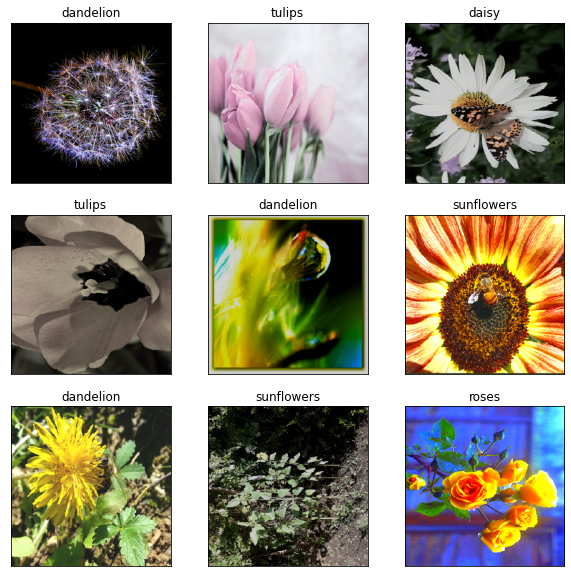

In [ ]:
images, labels = next(it)
show_batch(images.numpy(), labels.numpy(), fig_num=3)